In [4]:
import sys
import torch as t
import numpy as np
from matplotlib import pyplot as plt
import json
from itertools import product
sys.path.append('/workspace/wilson/Finite-groups/src')
from model import MLP3, MLP4, InstancedModule
from utils import *
from group_data import *
from model_utils import *
from jaxtyping import Float
from typing import Union
from einops import repeat
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import copy
import math
from itertools import product
from llc import *
from sklearn.decomposition import PCA
%load_ext autoreload
%autoreload 2

device = t.device("cuda" if t.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
#path = '/workspace/models/2024_08_02_02_17_18_S_5_'
# path = '/workspace/models/2024_08_03_00_04_30_Z_48_2_'
path = '/workspace/models/2024_08_05_18_31_53_S_5__times_A_5__Z_2__'
models, params = load_models(path, sel='final')

In [6]:
dataset = GroupData(params)

Intersection size: 7920/14400 (0.55)
Added 7920 elements from intersection
Added 0 elements from group 0: S(5)
Added 0 elements from group 1: times(A(5),Z(2))
Train set size: 7920/14400 (0.55)


In [7]:
model = models[-1][[0, 55, 97]].to(device)   # grokked G0, G1, neither

In [8]:
# make this constant to avoid accidentally reordering
PARAM_NAMES = [name for name, _ in model.named_parameters()]

In [9]:
eps = 8e-4
beta = 1e3
gamma = 1.

trace, traj = sgld_trace(model, dataset, eps, beta, gamma, epochs=3_000, behavioral=True, return_traj=True)

SGLD:   0%|          | 0/3000 [00:00<?, ?it/s]

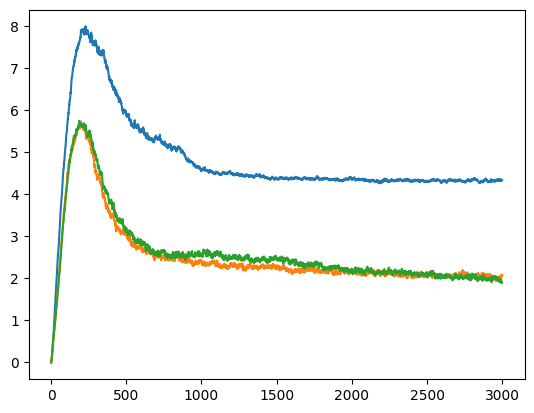

In [11]:
for i in range(trace.shape[0]):
    plt.plot(trace[i].cpu().numpy())
plt.show()

In [12]:
def flatten_model(model):
    return t.concat([model.get_parameter(name).flatten() for name in PARAM_NAMES])

In [13]:
def form_model(model, weights):
    numels = [model.get_parameter(name).numel() for name in PARAM_NAMES]
    bounds = [0] + list(np.cumsum(numels))
    shapes = [model.get_parameter(name).shape for name in PARAM_NAMES]
    ret = copy.deepcopy(model)
    for i, name in enumerate(PARAM_NAMES):
        p = ret.get_parameter(name)
        p.data = t.tensor(weights[bounds[i]:bounds[i + 1]]).reshape(shapes[i])
    return ret

In [38]:
model_idx = 2

In [39]:
orig_weights = flatten_model(model[model_idx]).cpu().detach().numpy()
weights = t.stack([flatten_model(m[model_idx]) for m in traj]).cpu().detach().numpy()
weights -= orig_weights
pca = PCA(n_components=20)
pca.fit(weights)
pca0 = pca.components_[0]
pca1 = pca.components_[1]
t0 = weights @ pca0.reshape((-1, 1))
t1 = weights @ pca1.reshape((-1, 1))
bound0 = np.abs(t0).max() * 1.2
bound1 = np.abs(t1).max() * 1.2

In [40]:
steps = 10
grid = np.stack(
    [pca0 * a + pca1 * b for a, b in product(np.arange(-bound0, bound0, bound0 / steps), np.arange(-bound1, bound1, bound1 / steps))]
)

In [41]:
grid_model = model[model_idx].stack(
    [form_model(model[model_idx], orig_weights + grid[i]).float() for i in range(len(grid))]
)

In [42]:
# BEHAVORIAL
X = t.tensor(list(dataset.train_data))[:, :2].to(device)
Y = model[model_idx].to(device)(X)
out = grid_model.to(device)(X)
Y = einops.repeat(Y, "batch instance vocab -> batch (n instance) vocab", n = len(grid_model))
loss = (Y.softmax(dim=-1) * (Y.log_softmax(dim=-1) - out.log_softmax(dim=-1))).sum(dim=-1).mean(dim=0)
loss = loss.reshape((2*steps, 2*steps)).detach().cpu().numpy()

In [13]:
# STANDARD
X = t.tensor(list(dataset.train_data))[:, :2].to(device)
Z = t.tensor(list(dataset.train_data))[:, 2].to(device)
out = grid_model.to(device)(X)
loss = get_cross_entropy(out, Z)
loss = loss.reshape((2*steps, 2*steps)).detach().cpu().numpy()

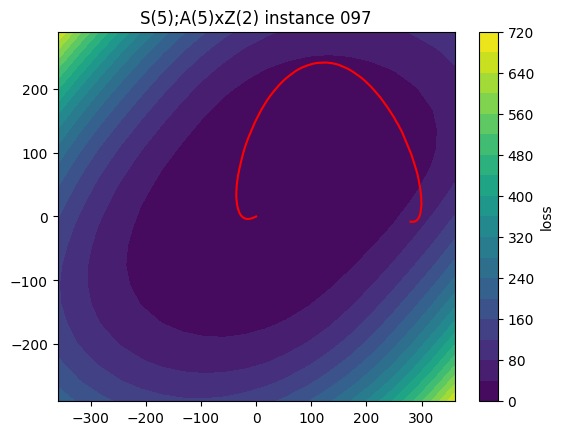

In [43]:
a = np.linspace(-bound0, bound0, 2*steps)
b = np.linspace(-bound1, bound1, 2*steps)
A, B = np.meshgrid(a, b)
plt.contourf(A, B, loss, levels=20, cmap='viridis')
plt.plot(t0.flatten(), t1.flatten(), 'r')
plt.colorbar(label='loss')
plt.title('S(5);A(5)xZ(2) instance 097')
plt.show()

In [121]:
x = np.array([a*10 + b for a, b in product(range(10), repeat=2)])

In [123]:
x.reshape(10, 10)

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
       [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
       [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
       [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])

In [203]:
import gc
t.cuda.empty_cache()
gc.collect()

1636

In [79]:
prods = [np.inner(pca1, weights[i].detach().numpy()) for i in range(3000)]

In [77]:
pca.singular_values_

array([1199.3876  ,  598.91547 ,  401.58405 ,  300.07877 ,  239.94913 ,
        199.4039  ,  171.28145 ,  150.01237 ,  133.04556 ,  120.010475,
        109.09311 ,   99.89379 ,   92.23335 ,   85.586586,   80.196915,
         75.20208 ,   70.63641 ,   66.626724,   63.153687,   59.965176],
      dtype=float32)

In [78]:
np.sqrt(1200)

np.float64(34.64101615137755)

In [81]:
min(prods)

np.float32(-31.185738)

In [83]:
weights.shape

torch.Size([3000, 157696])

In [86]:
r = weights.detach().numpy() @ pca0.reshape((-1, 1))

In [92]:
np.abs(r).max()

np.float32(61.71155)

In [32]:
pca.components_[0].shape

(157696,)

In [33]:
[p.numel() for p in model.parameters()]

[30720, 30720, 65536, 30720]

In [34]:
[name for name, _ in model.named_parameters()]

['embedding_left', 'embedding_right', 'linear', 'unembedding']

In [35]:
256*120

30720

In [36]:
np.cumsum([1, 2, 3, 4, 5])

array([ 1,  3,  6, 10, 15])

In [40]:
model.get_parameter('linear').shape

torch.Size([1, 256, 256])

[30720, 30720, 65536, 30720]
[0, np.int64(30720), np.int64(61440), np.int64(126976), np.int64(157696)]
[torch.Size([1, 120, 256]), torch.Size([1, 120, 256]), torch.Size([1, 256, 256]), torch.Size([1, 256, 120])]


/tmp/ipykernel_9749/1820372507.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p.data = t.tensor(weights[bounds[i]:bounds[i + 1]]).reshape(shapes[i])


In [66]:
idx = 500
a = form_model(model, weights[idx])
for name in PARAM_NAMES:
    print(name, (a.get_parameter(name) - traj[idx].get_parameter(name)).norm().item())

[30720, 30720, 65536, 30720]
[0, np.int64(30720), np.int64(61440), np.int64(126976), np.int64(157696)]
[torch.Size([1, 120, 256]), torch.Size([1, 120, 256]), torch.Size([1, 256, 256]), torch.Size([1, 256, 120])]
embedding_left 5.525967597961426
embedding_right 5.547910213470459
linear 8.06786060333252
unembedding 5.5435380935668945


/tmp/ipykernel_9749/1820372507.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p.data = t.tensor(weights[bounds[i]:bounds[i + 1]]).reshape(shapes[i])


In [58]:
a.linear

Parameter containing:
tensor([[[ 1.7425e-23,  3.1198e-12,  8.6314e-06,  ..., -8.4923e-02,
           1.9196e-14,  7.7403e-10],
         [-5.0651e-23, -8.2180e-12, -2.0085e-05,  ..., -1.9541e-02,
          -1.0730e-14,  4.5809e-09],
         [-3.1173e-23, -9.3005e-12, -5.3586e-07,  ..., -3.0710e-01,
          -1.3525e-14, -3.1426e-09],
         ...,
         [ 2.0064e-22,  2.7726e-12,  1.5972e-05,  ..., -1.9245e-01,
           6.9926e-15,  9.1588e-09],
         [-2.4655e-22,  4.1875e-12,  1.3858e-05,  ...,  2.8031e-01,
           1.6148e-15,  2.3248e-09],
         [-1.2222e-22, -4.2205e-12,  6.5678e-06,  ..., -4.5659e-01,
          -1.4531e-15, -4.5126e-09]]], requires_grad=True)

In [59]:
traj[0].linear

Parameter containing:
tensor([[[ 1.7425e-23,  3.1198e-12,  8.6314e-06,  ..., -8.4923e-02,
           1.9196e-14,  7.7403e-10],
         [-5.0651e-23, -8.2180e-12, -2.0085e-05,  ..., -1.9541e-02,
          -1.0730e-14,  4.5809e-09],
         [-3.1173e-23, -9.3005e-12, -5.3586e-07,  ..., -3.0710e-01,
          -1.3525e-14, -3.1426e-09],
         ...,
         [ 2.0064e-22,  2.7726e-12,  1.5972e-05,  ..., -1.9245e-01,
           6.9926e-15,  9.1588e-09],
         [-2.4655e-22,  4.1875e-12,  1.3858e-05,  ...,  2.8031e-01,
           1.6148e-15,  2.3248e-09],
         [-1.2222e-22, -4.2205e-12,  6.5678e-06,  ..., -4.5659e-01,
          -1.4531e-15, -4.5126e-09]]], requires_grad=True)